### Date: 8 Apr 2022

## Home test for Data Scientist
- Bạn hãy xây dựng một simple search engine bằng cách chuyển đổi text thành vector sử dụng TF-IDF. Dữ liệu gồm tên của sản phẩm trong file product_names.txt (gồm 50,000 tên của sản phẩm) và 100 query trong file 100_query.txt.
- Model của bạn sẽ là một matrix 50,000x10, với 10 ở đây là 10 thành phần có eigenvalues lớn nhất khi sử dụng PCA để reduce số chiều từ product document matrix được xây dựng từ các TF-IDF vector của product names.
- Quá trình search sẽ bao gồm 3 bước, biến query thành vector, giảm số chiều của query vector thành 10 và tìm ra các product reduced vector có khoảng cách gần với query reduced vector nhất.
- Các yêu cầu:
    + Bạn cần chạy model trên 100 query với giới hạn mỗi query là 5 kết quả.
    + Bạn có thể tuning tùy ý các hyper parameters để có được kết quả tốt nhất, tuy nhiên bạn theo cách làm trên.
    + Bạn cũng có thể đề xuất thêm giải pháp khác và khiển khai nếu có thể.
    + Bạn nên viết README, để hướng dẫn việc chạy code đã viết.

# 0. Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import import_ipynb
import Lib

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.options.display.float_format = '{:,.4f}'.format

importing Jupyter notebook from Lib.ipynb


In [2]:
import re
import pickle
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import math

# 1. EDA

product_names.txt

In [3]:
# Load 'product_names.txt'
product = pd.read_csv('data/product_names.txt', sep='delimiter', header=None, names=['names'])
product.shape

(49991, 1)

In [4]:
product.head(10)

,names
0,dép quai ngang phối kim tuyến mirabella dep773...
1,rinne- tập 12
2,tai nghe day joyroom jr-e203 (xam)
3,giấy nhắc nhở dán lịch - loại 3
4,"đầm a kiểu croptop phủ voan hàn quốc, đính nơ ..."
5,new headway pronunciation course: student's pr...
6,adapter sac 3 cong promate 30w ho tro qc 3.0 ...
7,balo cat cage covers 83112 (42 x 29 cm) - đen
8,giay tay nam claude aston clarks 26124130 blac...
9,kem nền serum bobbi brown intensive skin serum...


In [5]:
product.tail(10)

,names
49981,set do dung cu boi danh cho ca nam va nu mau h...
49982,áo thun nhộng v for vietnam-xs
49983,english for life intermediate: workbook with k...
49984,giày bít mũi nữ phối nơ nados h05009
49985,kẻ mắt nước không trôi etude house poof 10 liq...
49986,giày đi bộ đường dài shindo mid gtx w - l40238...
49987,move ahead level one grammar practice
49988,bo quan ao mo vai hinh voi truot patin bieber ...
49989,hop hoa hong 12
49990,ao ba lo nam f2 fashion f2-bl-08 - trang kem (...


In [6]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49991 entries, 0 to 49990
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   names   49991 non-null  object
dtypes: object(1)
memory usage: 390.7+ KB


In [7]:
# Check & drop duplicated rows
print('Number of duplicated rows:',product.duplicated().sum())
product = product.drop_duplicates().reset_index(drop=True)
product.shape

Number of duplicated rows: 629


(49362, 1)

In [8]:
# Check if there is any null value
product.isnull().any()

names    False
dtype: bool

In [9]:
# Reset index
product = product.reset_index(drop=True)

Write a function <font color='green'>**clean_function**</font> to clean data:
- Contents of Product['names'] are in Vietnamese (with marks or without marks), English, and non-alphabet languages (such as: Chinese) => <font color='green'>**Keep only contents in Vietnamese and English**</font>
- <font color='green'>**Numberic characters will be kept**</font> as they could be product model.., although <font color='green'>**leading zero characters or zero values ('00','000'..) will be dropped out**</font>.
- <font color='green'>**Drop out extra spaces**</font>
- <font color='green'>**Drop out spaces**</font> at beginning/ ending of the sentences

In [10]:
# apply clean_function to product['names']
product['clean_names'] = product['names'].apply(lambda x: Lib.clean_function(x))
product.head()

,names,clean_names
0,dép quai ngang phối kim tuyến mirabella dep773...,dép_quai_ngang phối kim_tuyến mirabella dep773...
1,rinne- tập 12,rinne tập 12
2,tai nghe day joyroom jr-e203 (xam),tai nghe day joyroom jr e203 xam
3,giấy nhắc nhở dán lịch - loại 3,giấy nhắc_nhở dán lịch loại 3
4,"đầm a kiểu croptop phủ voan hàn quốc, đính nơ ...",đầm a kiểu croptop phủ voan hàn quốc đính nơ c...


In [11]:
# calculate number of words of each product_names
product['words'] = product['clean_names'].map(lambda x: len(x.split()))
product.head()

,names,clean_names,words
0,dép quai ngang phối kim tuyến mirabella dep773...,dép_quai_ngang phối kim_tuyến mirabella dep773...,6
1,rinne- tập 12,rinne tập 12,3
2,tai nghe day joyroom jr-e203 (xam),tai nghe day joyroom jr e203 xam,7
3,giấy nhắc nhở dán lịch - loại 3,giấy nhắc_nhở dán lịch loại 3,6
4,"đầm a kiểu croptop phủ voan hàn quốc, đính nơ ...",đầm a kiểu croptop phủ voan hàn quốc đính nơ c...,16


In [12]:
product.to_csv('data/product_names_clean.csv')

In [13]:
product.describe().T

,count,mean,std,min,25%,50%,75%,max
words,"49,362.0000",10.0175,3.9697,1.0000,7.0000,10.0000,12.0000,42.0000


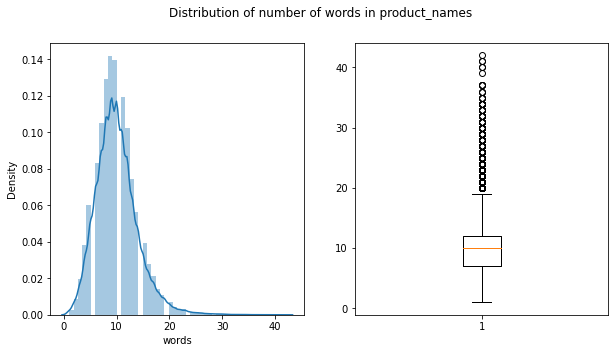

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.distplot(product.words)
plt.subplot(122)
plt.boxplot(product.words)
plt.suptitle('Distribution of number of words in product_names')
plt.show()

- Most of Product names are from 5-10 words, the most popular length is 10 (words)

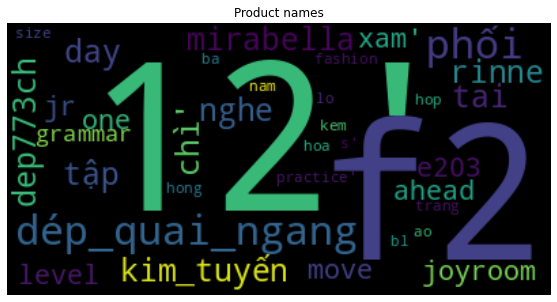

In [15]:
# WordCloud
wc= WordCloud(background_color='black')
wc.generate(str(product['clean_names'].values))
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.title('Product names')
plt.axis('off')
plt.show()

'100_query.txt'

In [16]:
# Load data 'query.csv'
query = pd.read_csv('data/100_query.txt', header=None, names=['query'])
query.shape

(100, 1)

In [17]:
query.head()

,query
0,sách
1,tai nghe
2,balo
3,anker
4,bitis


In [18]:
query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   query   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [19]:
print('Number of duplicated rows:', query.duplicated().sum())
query = query.drop_duplicates().reset_index(drop=True)
query.shape

Number of duplicated rows: 0


(100, 1)

In [20]:
# Check if there is any null value
query.isnull().any()

query    False
dtype: bool

In [21]:
# Apply clean_function to query
query['clean_query'] = query['query'].apply(lambda x: Lib.clean_function(x))

In [22]:
query.head(10)

,query,clean_query
0,sách,sách
1,tai nghe,tai nghe
2,balo,balo
3,anker,anker
4,bitis,bitis
5,conan,conan
6,xiaomi,xiaomi
7,nguyễn nhật ánh,nguyễn_nhật ánh
8,đắc nhân tâm,đắc_nhân_tâm
9,harry potter,harry potter


In [23]:
query.tail(10)

,query,clean_query
90,thẻ cào,thẻ cào
91,nguyen nhat anh,nguyen nhat anh
92,innisfree,innisfree
93,giày nữ,giày nữ
94,ehon,ehon
95,blockchain,blockchain
96,za,za
97,light novel,light novel
98,máy nghe nhạc,máy nghe nhạc
99,sổ,sổ


In [24]:
# calculate number of words of each query
query['words'] = query['clean_query'].map(lambda x: len(x.split()))
query.head()

,query,clean_query,words
0,sách,sách,1
1,tai nghe,tai nghe,2
2,balo,balo,1
3,anker,anker,1
4,bitis,bitis,1


In [25]:
query.to_csv('data/query_clean.csv')

In [26]:
query.describe().T

,count,mean,std,min,25%,50%,75%,max
words,100.0000,1.6700,0.7921,1.0000,1.0000,1.0000,2.0000,4.0000


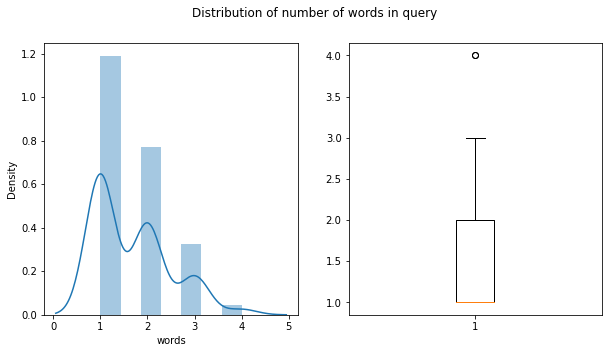

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.distplot(query.words)
plt.subplot(122)
plt.boxplot(query.words)
plt.suptitle('Distribution of number of words in query')
plt.show()

- Most of queries are from 1-3 words, the longest query has 4 words¶

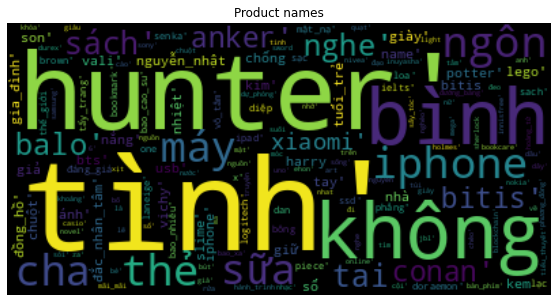

In [28]:
# WordCloud
wc2= WordCloud(background_color='black')
wc2.generate(str(query['clean_query'].values))
plt.figure(figsize=(10, 5))
plt.imshow(wc2, interpolation='bilinear')
plt.title('Product names')
plt.axis('off')
plt.show()

# 2. Data Preparation

Load Vietnamese stopwords and combine with English stopwords

In [29]:
# import Vietnamese stopwords
with open('data/vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [30]:
# Vectorize product names using TF-IDF
tf = TfidfVectorizer(analyzer='word', stop_words=stop_words, min_df=0)
tf = tf.fit(product['clean_names'])
tfidf_matrix = tf.transform(product['clean_names'])
tfidf_matrix.shape

(49362, 43663)

In [31]:
# Convert tfidf_matrix to dataframe
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), 
                        columns=tf.get_feature_names()
                       )
tfidf_matrix.head()

,10,100,1000,10000,10001,10002,1000250,1000257,10003,1000347,...,ớt,ớt_hiểm,ủi,ủy,ủy_quyền,ủy_thác,ứng_dụng,ứng_phó,ứng_xử,ứớt
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [32]:
# Reduce dimension of tfidf_matrix using Principal component analysis
pca = PCA(n_components=10, svd_solver='randomized', random_state=42)
pca = pca.fit(tfidf_matrix)
names_pca = pca.transform(tfidf_matrix)

In [33]:
names_pca.shape

(49362, 10)

In [34]:
# save tfidf result and pca result to csv
pd.DataFrame(names_pca).to_csv("data/names_pca.csv")

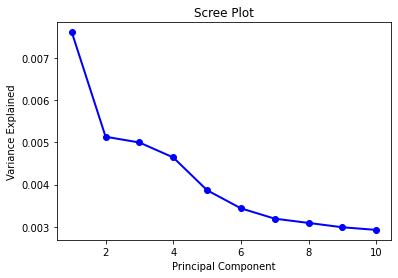

In [35]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [36]:
print(pca.explained_variance_ratio_)

[0.00761216 0.00513455 0.00499807 0.00464378 0.00386702 0.00343739
 0.00319274 0.00309117 0.0029884  0.00292551]


In [37]:
print(pca.explained_variance_ratio_.sum())

0.04189077421163399


- Tổng phương sai giữ lại sau khi PCA chỉ còn ~4% - khá là thấp, có thể nhiều thông tin đã bị mất khi PCA.
- Để kiểm tra, ta sẽ tiến hành reverse PCA và tính rmse của dữ liệu sau khi reverse với dữ liệu gốc.

In [38]:
# Reverse PCA
mu = np.mean(tfidf_matrix, axis=0)
nComp = 10
rev_names_pca = np.dot(pca.transform(tfidf_matrix)[:,:nComp], pca.components_[:nComp,:])
rev_names_pca += mu

rev_names_pca[0,]

array([ 5.69091530e-03, -2.48816695e-04,  7.15434961e-04, ...,
        9.52111718e-06,  4.01639497e-05,  1.43810442e-05])

In [39]:
#Check the shape of the reversed data
rev_names_pca.shape

(49362, 43663)

In [40]:
#Calculate root mean square error
mse = mean_squared_error(tfidf_matrix, rev_names_pca)
rmse = math.sqrt(mse)
rmse

0.0046691464792278725

In [41]:
#Calculate standard deviation
std = tfidf_matrix.std().mean()
std

0.0035336455130205494

- Ta thấy rằng hai chỉ số RMSE và std không chênh lệch quá nhiều nên ta có thể chấp nhận kết quả PCA này.

In [42]:
#Save models
with open('tfidf.pkl', 'wb') as file:  
    pickle.dump(tf, file)
with open('pca.pkl', 'wb') as file:  
    pickle.dump(pca, file)

# 3. Build Search Engine
Technique used:
1. NearestNeighbors with PCA and with out PCA
2. Cosine Similarity with PCA and with out PCA
3. Jaccard Similarity (Character Similarity)
4. Gensim


## 3.1.a NearestNeighbors with PCA 
Write functions for Search a single query, include below steps:
- Load the models (tfidf, pca)
- Load the data
- Apply clean_funtion to query
- Vectorize query
- Reduce dimension to 10 components
- Fit data and Find 5 nearest neighbors
- Return results

In [43]:
# Search a specific query
Lib.nearestNeighbors_search('tiểu thuyết')

Time: 0.28931093215942383


,product_names,distance
0,bố mẹ yên tâm con làm được - con là điều tuyệt...,0.0004
1,thông điệp từ gã tư bản ngoan cố,0.0004
2,nỗi ân hận của cô tiên,0.0004
3,queen of babble,0.0004
4,bút dạ quang hl38 - lục,0.0004


In [44]:
# Search a specific query
Lib.nearestNeighbors_search('giày')

Time: 0.22732305526733398


,product_names,distance
0,giày thể thao w đen (size 40),0.1844
1,giày búp bê chạy chỉ - đen (size 39),0.2043
2,giày cao gót công sở nữ - đen (size 38),0.2166
3,giày búp bê nhung nơ to - đen (size 37),0.2228
4,giày cao gót nữ quai chéo - đen (size 39),0.2235


In [45]:
# Search a specific query
Lib.nearestNeighbors_search('anker')

Time: 0.22506403923034668


,product_names,distance
0,pin aaa energizer advanced x92 rp4,0.0029
1,bull (bull) gn-j610type-c anti-break data cabl...,0.0032
2,loa dalton ksn-412,0.0039
3,may cao rau pisen shaving power smpw302 (5000mah),0.0040
4,loa vi tinh creative sbs a120 2.1 9w,0.0040


## 3.1.b NearestNeighbors with out PCA 
Write functions for Search a single query, include below steps:
- Load the models (tfidf)
- Load the data
- Apply clean_funtion to query
- Vectorize query
- Fit data and Find 5 nearest neighbors
- Return results

In [47]:
# Search a specific query
Lib.nearestNeighbors_search_noPCA('tiểu thuyết', tfidf_matrix)

Time: 20.581259965896606


,product_names,distance
0,cuốn sổ màu xanh (tiểu thuyết),0.7597
1,hùng binh (tiểu thuyết lịch sử),0.9487
2,những đứa trẻ chết già (tiểu thuyết),0.9870
3,một với một là ba,1.0000
4,vượt lên chính mình 2,1.0000


In [48]:
# Search a specific query
Lib.nearestNeighbors_search_noPCA('giày', tfidf_matrix)

Time: 19.78966188430786


,product_names,distance
0,giày tập đi,0.8731
1,more of me,1.0000
2,before after,1.0000
3,why not me,1.0000
4,đi đâu cũng nhớ sài gòn và... em.,1.0000


In [49]:
# Search a specific query
Lib.nearestNeighbors_search_noPCA('anker', tfidf_matrix)

Time: 20.27421283721924


,product_names,distance
0,sạc dự phòng anker powercore+ 10050mah đen và ...,0.9981
1,một với một là ba,1.0000
2,before after,1.0000
3,why not me,1.0000
4,anh sẽ vì em mà ở lại?,1.0000


## 3.2.a Cosine Similarity with PCA

Write 02 functions for 02 options **Search all 100 provided queries** & **Search a single query**, include below steps:
- Load the models (tfidf, pca)
- Load the data
- Apply clean_funtion to query
- Vectorize query
- Reduce dimension to 10 components
- Create cosine_similarities matrix
- Return top 5 products having the highest cosine_similarities

In [50]:
# Search a specific query
Lib.cosine_search('tiểu thuyết')

Time: 0.21930170059204102


,product_names,sim_score
0,bút dạ quang hl38 - lục,1.0000
1,nỗi ân hận của cô tiên,1.0000
2,ba chàng ngốc,1.0000
3,côn trùng gớm ghiếc,1.0000
4,bố mẹ yên tâm con làm được - con là điều tuyệt...,1.0000


In [51]:
Lib.cosine_search('giày')

Time: 0.21462225914001465


,product_names,sim_score
0,giày búp bê domani gb30de - đen-35,0.9909
1,giày búp bê bb163b đen,0.9909
2,giày nơ - hmf702 - đen - 37,0.9910
3,giày búp bê trơn - hmf707 - đen - 38,0.9928
4,giày búp bê - nơ huy hiệu f - đen - 39,0.9949


In [52]:
Lib.cosine_search('son')

Time: 0.21615099906921387


,product_names,sim_score
0,son bam dang li eco soul kiss button lips matt...,0.9985
1,binh xit phun son a211 - do,0.9987
2,thời sinh dự đoán tương lai và cách hóa giải,0.9988
3,torin vertical hydraulic jacks auto repair too...,0.9989
4,thân nhiệt quyết định sinh lão bệnh tử,0.9990


In [53]:
Lib.cosine_search('anker')

Time: 0.21440410614013672


,product_names,sim_score
0,pin aaa energizer advanced x92 rp4,0.9992
1,cáp hdmi ugreen 30192,0.9992
2,bull (bull) gn-j610type-c anti-break data cabl...,0.9993
3,đầu đọc thẻ transcend ts-rdf5k 90/60 mb/s ...,0.9993
4,green (ugreen) usb data cable 2.0 male to fema...,0.9996


In [54]:
# Search all provided queries
results = Lib.cosine_search_all(query['clean_query'])

Time: 29.43670392036438


In [55]:
results[:20]

,query,product_names,sim_score
0,sách,tủ sách sputnik - các bài giảng về toán cho mi...,0.9998
1,sách,hướng dẫn học ccna routing & switching,0.9998
2,sách,trọng tâm kiến thức và phương pháp giải toán ...,0.9999
3,sách,bài giảng & hướng dẫn chi tiết toán 3/1,0.9999
4,sách,kỹ năng sống - 101 câu chuyện học sinh cần đọc...,0.9999
5,tai nghe,tai nghe sennheiser hd 180 chụp tai,0.9846
6,tai nghe,tai nghe nhét tai philips she7050,0.9850
7,tai nghe,tai nghe sennheiser pmx 90 trên tai,0.9853
8,tai nghe,10 sai lam trong quan ly tai chinh (tai ban 2015),0.9855
9,tai nghe,tai nghe sennheiser hd 201 chup tai,0.9919


## 3.2.b Cosine Similarity without PCA
Write a function for Search a single query, include below steps:
- Load the model (tfidf)
- Load the data
- Apply clean_funtion to query
- Vectorize query
- Create cosine_similarities matrix
- Return top 5 products having the highest cosine_similarities

In [56]:
Lib.cosine_search_noPCA('tiểu thuyết', tfidf_matrix=tfidf_matrix)

Time: 36.434873819351196


,product_names,sim_score
0,cõi người rung chuông tận thế (tiểu thuyết),0.4549
1,tiểu thuyết trinh thám 1/14 - tập 3 - lời cảnh...,0.4915
2,những đứa trẻ chết già (tiểu thuyết),0.5129
3,hùng binh (tiểu thuyết lịch sử),0.5500
4,cuốn sổ màu xanh (tiểu thuyết),0.7115


In [57]:
Lib.cosine_search_noPCA('giày', tfidf_matrix=tfidf_matrix)

Time: 34.67091608047485


,product_names,sim_score
0,giày tây nam da bò giày huy t952 - đen (size 41),0.4062
1,giày thể thao w đen (size 40),0.4123
2,giày tập đi bé gái,0.4146
3,giày mọi nam da bò giày huy k346 - nâu (size 41),0.4251
4,giày tập đi,0.6189


In [58]:
Lib.cosine_search_noPCA('anker', tfidf_matrix=tfidf_matrix)

Time: 36.09446477890015


,product_names,sim_score
0,cap sac lightning anker powerline+ 0.3m - xam...,0.3899
1,cáp sạc micro usb anker 1.8m - a7104,0.4138
2,loa di dong anker classic 4w- a7908,0.4227
3,adapter sạc 2 cổng usb anker (24w) – trắng,0.4464
4,sạc dự phòng anker powercore+ 10050mah đen và ...,0.5019


## 3.3 Jaccard similarity
Write a function for Search a single query, include below steps:
- Load the data
- Apply clean_funtion to query
- Split and get unique text in query
- Iterate product['clean_names]: 
    + Split and get unique text of each elements
    + Compute intersection of the element and query
    + Compute union of the element and query
- Calculate Jaccard similarity score
- Return top 5 products having the highest cosine_similarities

In [59]:
Lib.jaccard_search('tiểu thuyết')

Time: 32.12851405143738


,product_names,jaccard_score
0,hùng binh (tiểu thuyết lịch sử),0.2500
0,cuốn sổ màu xanh (tiểu thuyết),0.2000
0,những đứa trẻ chết già (tiểu thuyết),0.2000
0,chuyện phiếm của hội con gái (tiểu thuyết blog),0.1667
0,cõi người rung chuông tận thế (tiểu thuyết),0.1667


In [60]:
Lib.jaccard_search('giày')

Time: 31.939516067504883


,product_names,jaccard_score
0,giày tập đi,0.3333
0,giày sneakers nam jordan,0.2500
0,giày đá banh fm501,0.2500
0,giày lười thể thao sp24,0.2500
0,giày thể thao nam phong cách - xanh,0.2500


In [61]:
Lib.jaccard_search('anker')

Time: 31.744436979293823


,product_names,jaccard_score
0,loa bluetooth anker soundcore mini - a3101111 ...,0.1429
0,loa di dong anker classic 4w- a7908,0.1429
0,loa di động anker premium stereo 20w - a3143h11,0.1250
0,sạc dự phòng anker powercore 15600 - màu đen -...,0.1250
0,cáp sạc micro usb anker 1.8m - a7104,0.1111


## 3.4 Gensim

In [62]:
product.head()

,names,clean_names,words
0,dép quai ngang phối kim tuyến mirabella dep773...,dép_quai_ngang phối kim_tuyến mirabella dep773...,6
1,rinne- tập 12,rinne tập 12,3
2,tai nghe day joyroom jr-e203 (xam),tai nghe day joyroom jr e203 xam,7
3,giấy nhắc nhở dán lịch - loại 3,giấy nhắc_nhở dán lịch loại 3,6
4,"đầm a kiểu croptop phủ voan hàn quốc, đính nơ ...",đầm a kiểu croptop phủ voan hàn quốc đính nơ c...,16


In [63]:
#Tokenize(split) sentence into words
names_ = [[text for text in x.split()] for x in product['clean_names']]

In [64]:
#Remove both vietnamese and english stop words in texts
names_ = [[t for t in text if not t in stop_words] for text in names_] # stopword

In [65]:
#Creating term dictionary
dictionary = corpora.Dictionary(names_)

In [66]:
#Feature Extraction (Bag of Words)
corpus = [dictionary.doc2bow(desc) for desc in names_]

In [67]:
#Build Tf-Idf and LSI Model
name_tfidf_model = models.TfidfModel(corpus, id2word=dictionary)
name_lsi_model = models.LsiModel(name_tfidf_model[corpus], id2word=dictionary, num_topics=1000)

In [68]:
#Serialize and Save the corpus 
corpora.MmCorpus.serialize('data/name_tfidf_model_mm', name_tfidf_model[corpus])
corpora.MmCorpus.serialize('data/name_lsi_model_mm',name_lsi_model[name_tfidf_model[corpus]])

In [69]:
#Load the indexed corpus
name_tfidf_corpus = corpora.MmCorpus('data/name_tfidf_model_mm')
name_lsi_corpus = corpora.MmCorpus('data/name_lsi_model_mm')

print(name_tfidf_corpus)
print(name_lsi_corpus)

MmCorpus(49362 documents, 43705 features, 437096 non-zero entries)
MmCorpus(49362 documents, 1000 features, 49339991 non-zero entries)


In [70]:
#Create MatrixSimilarit matrix
name_index = similarities.MatrixSimilarity(name_lsi_corpus, num_features = name_lsi_corpus.num_terms)

In [71]:
# Search a single query
Lib.gensim_search('anker', dictionary=dictionary, similarities_matrix=name_index,
                  name_tfidf_model=name_tfidf_model, name_lsi_model=name_lsi_model)

Time: 0.13905787467956543


,product_names,gensim_score
0,dây cáp sạc micro usb anker powerline 3.0m - a...,59.7400
1,sạc dự phòng anker powercore+ 10050mah đen và ...,59.2900
2,dây cáp sạc micro usb anker powerline 1.8m - a...,56.6200
3,cáp sạc micro usb anker powerline 0.3m - trắ...,55.6500
4,cap sac anker powerline micro usb 3.0m - trang...,55.5500


In [72]:
Lib.gensim_search('sách', dictionary=dictionary, similarities_matrix=name_index,
                  name_tfidf_model=name_tfidf_model, name_lsi_model=name_lsi_model)

Time: 0.1481180191040039


,product_names,gensim_score
0,sách ngược đời xuôi,99.9400
1,sách chỉ dành cho đàn ông,99.8000
2,cuốn sách nhỏ về những thuyết quản lý lớn và c...,99.6600
3,cuốn sách kì diệu winfun 9019,99.3800
4,chặn sách bajing 0832,99.0500


In [73]:
Lib.gensim_search('giày', dictionary=dictionary, similarities_matrix=name_index,
                  name_tfidf_model=name_tfidf_model, name_lsi_model=name_lsi_model)

Time: 0.15568900108337402


,product_names,gensim_score
0,giày bóng đá nam mizuno giày monarcida 2 fs in...,59.3900
1,giày bóng đá nam mizuno giày monarcida 2 fs in...,58.7400
2,"giày jeep nam, giày thể thao nam leo núi lội n...",57.9600
3,giày tập đi,56.8700
4,giày cao gót qm48r,54.9900


In [74]:
Lib.gensim_search('tiểu thuyết', dictionary=dictionary, similarities_matrix=name_index,
                  name_tfidf_model=name_tfidf_model, name_lsi_model=name_lsi_model)

Time: 0.14273691177368164


,product_names,gensim_score
0,chuyện phiếm của hội con gái (tiểu thuyết blog),63.0700
1,cuốn sổ màu xanh (tiểu thuyết),43.4500
2,truyện và đời - khảo luận tiểu thuyết cổ điển ...,41.6300
3,hùng binh (tiểu thuyết lịch sử),41.6000
4,sổ lych50841-2905ch,40.1000


In [75]:
Lib.gensim_search('son', dictionary=dictionary, similarities_matrix=name_index,
                  name_tfidf_model=name_tfidf_model, name_lsi_model=name_lsi_model)

Time: 0.14839816093444824


,product_names,gensim_score
0,son bạch kim glossy lipstick asami - 150003 - ...,91.6700
1,son lâu phai quyến rũ tám cạnh glossy lipstick...,86.2900
2,son lâu phai quyến rũ tám cạnh glossy lipstick...,86.2600
3,letters from a skeptic: a son wrestles with hi...,82.9600
4,combo son lì butaé - no.14 + son lì butaé - no.7,77.0500


# 4. Conclusion
- As we can see, although the search results of cosine_noPCA are much better than cosine_withPCA, cosine_noPCA is more time consuming than cosine_withPCA (30 seconds vs 0.1 seconds)
- Both NearestNeighbors with PCA and without PCA return not good results
- Jaccard_similarities shows a quite good result but are also quite long time consuming (~20 seconds)
- Gensim shows  the results as good as cosine_noPCA but the speed of cosine_withPCA 
### => In conclusion, Gensim is considered to be the best solution.